# Librarys

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import seaborn as sns
import pandas as pd

# Functions

In [3]:
#Differential equations

def df1(y,t,params):   
    S,ZC,ZH,IC,IHC,IHH,MC, MH = y
    Lambda,phi,xi_C,xi_H,V_C,V_H,eta,alpha,gamma,beta,omega_H,omega_C,rho,delta_Z,delta_I,epsilon = params
    
    dS = Lambda*(S+ZC+ZH+IC+IHC+IHH) + gamma*ZC + alpha*ZH - rho*epsilon*beta*S*ZC - phi*S
    
    dZC = rho*epsilon*beta*S*ZC + omega_C*IC - xi_C*(1-gamma)*(1-delta_Z)*ZC - delta_Z*ZC - gamma*ZC - phi*ZC
    
    dZH = delta_Z*ZC + omega_H*(IHH+IHC) - xi_H*(1-alpha)*ZH - alpha*ZH - phi*ZH 
    
    dIC = xi_C*(1-gamma)*(1-delta_Z)*ZC - delta_I*IC - omega_C*IC - (1-omega_C)*(1-delta_I)*eta*V_C*IC - phi*IC
    
    dIHC = delta_I*IC-omega_H*IHC-(1-omega_H)*eta*V_H*IHC-phi*IHC
    
    dIHH = xi_H*(1-alpha)*ZH-omega_H*IHH-(1-omega_H)*eta*V_H*IHH-phi*IHH
    
    dMC = (1-omega_C)*(1-delta_I)*eta*V_C*IC
    
    dMH = (1-omega_H)*eta*V_H*IHC-phi*IHC + (1-omega_H)*eta*V_H*IHH-phi*IHH

    
    derivs = [dS,dZC,dZH,dIC,dIHC,dIHH,dMC,dMH]
        
    return derivs


#intervalo de confianza usando montecarlo

def CI_v1 (RESULTS):
# inputs:
# RESULTS[i] = resultado correspondiente a beta[i]
# RESULTS[i][:,j] = serie de tiempo para el compartimento j

#outputs:
#entrega mean = arreglo con los promedios, donde mean[i] corresponde a la serie del 
#    compartimento i 
#    low = arreglo con el límite inferior de intervalo de confianza al 95%, donde 
#    low[i] corresponde a la serie del comparimento i
#    up = arreglo con el límite inferior de intervalo de confianza al 95%, donde 
#    up[i] corresponde a la serie del comparimento i
#    MATRIZ = arreglo que reordena los elementos de RESULT, donde MATRIZ[c] es son
#    los resultados para el compartimento c, y donde MATRIZ[c][:,i] es la serie de tiempo
#    para el beta[i]
    
    n_beta = len(RESULTS)
    n_compartment = np.size(RESULTS[1],1)
    T = np.size(RESULTS[1],0)
    
    mean = []
    low = []
    up = []
    
    MATRIZ = []
    
    for c in range(n_compartment):

        matriz = np.zeros([T,n_beta])
        
        for i in range(n_beta):
            matriz[:,i] = RESULTS[i][:,c]
        
        mean_c =  np.mean(matriz,axis=1)
        std_c = np.std(matriz,axis=1)
#        se_c = std_c/np.sqrt(n_beta)
        
        low_c = mean_c - 1.96*std_c
        up_c = mean_c + 1.96*std_c
        
        mean.append(mean_c)
        low.append(low_c)
        up.append(up_c)
        MATRIZ.append(matriz)
        
    return mean, low, up, MATRIZ

#intervalo de confianza usando promedio de la serie

def CI_v2 (RESULTS):
# RESULTS[i] = resultado correspondiente a la serie de tiempo del compartimento i
    
    n_compartment = np.size(RESULTS,1)
    T = np.size(RESULTS,0)
    

    low = np.zeros([T,n_compartment])
    up = np.zeros([T,n_compartment])
    
    for i in range(n_compartment):
        
        std_i = np.std(RESULTS[:,i])
        low[:,i] = RESULTS[:,i]-1.96*std_i
        up[:,i] = RESULTS[:,i]+1.96*std_i
        
    return low, up
        

# Parameters and Initial Conditions

In [2]:
#parameters

Lambda= 0.000032
phi= 0.000019
xi_C= 0.00011
xi_H= 0.011
V_C= 0.368
V_H= 0.368
eta = 0.1
gamma= 0.033333
alpha = 0.32
beta = 0.0005308*0.18
omega_H= 0.1859
omega_C= 0.25*0.1859
rho= 1.27
delta_Z= 0.000054
delta_I= 0.95
epsilon= 0.01253

#Initial Conditions

N = 46000

S_0 = 0.5*N

Hospitalized = 0.0025*N 
Infected_Hospital = Hospitalized*0.0842


ZH_0 = Hospitalized*(1-0.0842)

IC_0 = Hospitalized*0.0842*0.5

IHC_0 = Infected_Hospital*0.87
IHH_0 = Infected_Hospital*0.17

ZC_0 = N-S_0-ZH_0-IC_0-IHC_0-IHH_0

MC_0 = 0
MH_0 = 0

y0 = [S_0,ZC_0,ZH_0,IC_0,IHC_0,IHH_0,MC_0,MH_0]
compartment_names = [r'$S$',r'$Z_C$',r'$Z_H$',r'$I_C$',r'$I_{HC}$',r'$I_{HH}$',r'$MC$',r'$MH$',r'$I_H$','N']

#timeline

tInc = 1
tStop = 700
t = np.arange(0,tStop,tInc)


# A]- Grafica de dinámica de todos compartimentos en misma imagen para dos escenarios de risk of transmission

In [5]:
#resultados

RHO = np.array([1,1.27])

RESULTS = []


for r in range(len(RHO)):
    parameters = Lambda,phi,xi_C,xi_H,V_C,V_H,eta,alpha,gamma,beta,omega_H,omega_C,RHO[r],delta_Z,delta_I,epsilon
    
    psoln = odeint(df1, y0, t, args=(parameters,)) #resolvemos el sistema
    IH = psoln[:,4]+psoln[:,5] #sumamos IH = IHH+IHC
    N = psoln[:,0]+psoln[:,1]+psoln[:,2]+psoln[:,3]+psoln[:,4]+psoln[:,5] #calculamos N
    solutions = np.append(psoln,np.atleast_2d(IH).T, axis=1) #lo agregamos a la lista
    solutions = np.append(solutions,np.atleast_2d(N).T, axis=1)

    RESULTS.append(solutions)

/Users/danieltoro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/Users/danieltoro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/danieltoro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments 

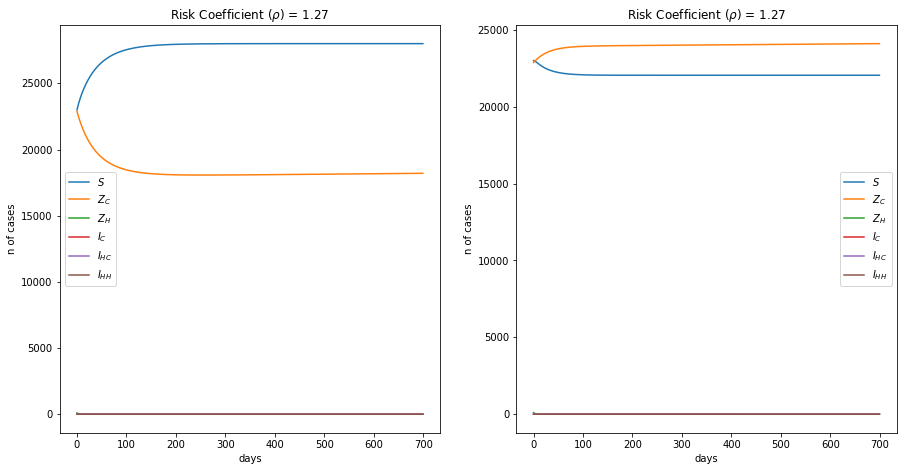

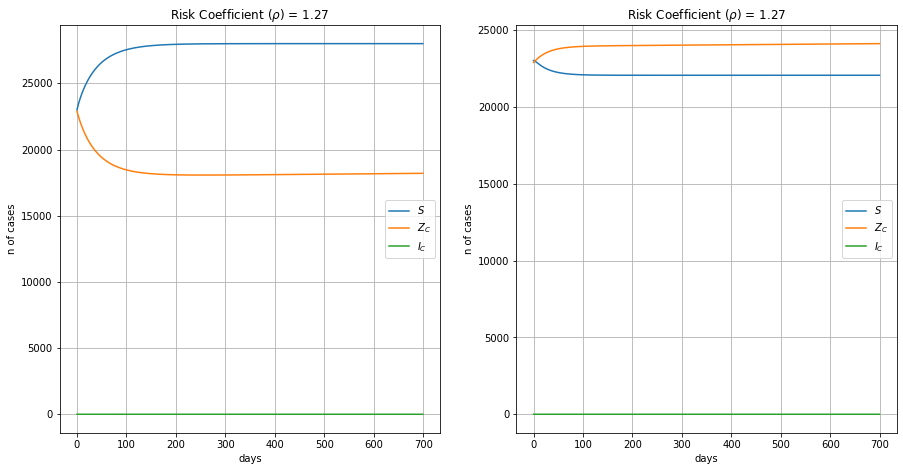

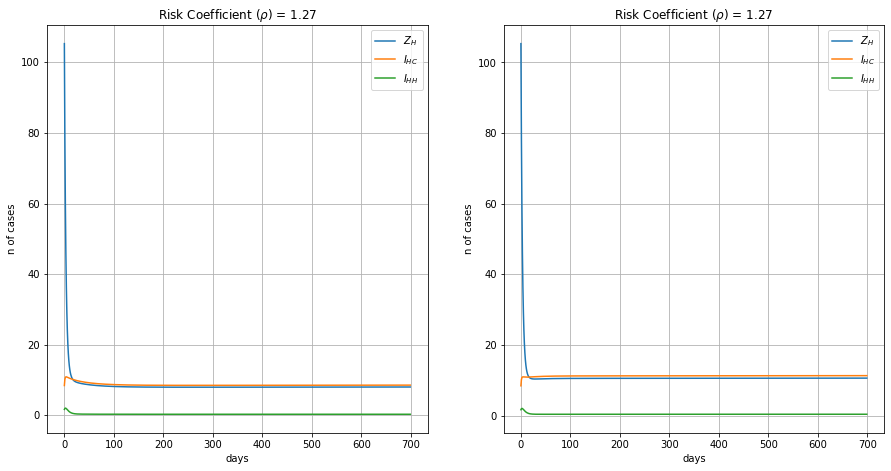

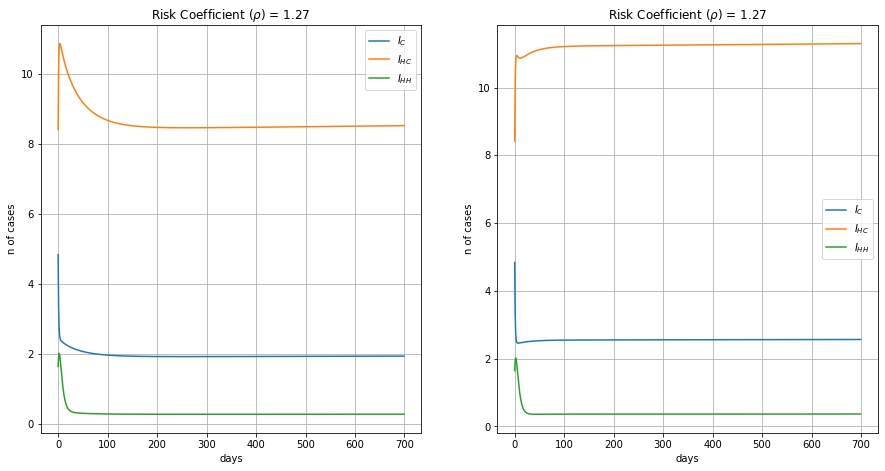

In [6]:
#gráficos

#TODOS    
f1, ax1 = plt.subplots(1,2, figsize=(15,7.5))    
for r in range(len(RHO)): 
    for i in range(8):
        solutions = RESULTS[r]
        if i<=5  :
            plt.subplot(1,2,r+1)
            plt.plot(solutions[:,i],label = compartment_names[i])
            plt.title(r'Risk Coefficient ($\rho$) = '+str(rho))
            plt.xlabel('days')
            plt.ylabel('n of cases')
            plt.grid()
            plt.legend()
            
#COMUNIDAD   
f2, ax2 = plt.subplots(1,2, figsize=(15,7.5))    
for r in range(len(RHO)): 
    for i in range(8):
        solutions = RESULTS[r]
        if i==0 or i == 1 or i == 3  :
            plt.subplot(1,2,r+1)
            plt.plot(solutions[:,i],label = compartment_names[i])
            plt.title(r'Risk Coefficient ($\rho$) = '+str(rho))
            plt.xlabel('days')
            plt.ylabel('n of cases')
            plt.grid()
            plt.legend()
            
#HOSPITAL 
f2, ax2 = plt.subplots(1,2, figsize=(15,7.5))    
for r in range(len(RHO)): 
    for i in range(8):
        solutions = RESULTS[r]
        if i==2 or i == 4 or i == 5  :
            plt.subplot(1,2,r+1)
            plt.plot(solutions[:,i],label = compartment_names[i])
            plt.title(r'Risk Coefficient ($\rho$) = '+str(rho))
            plt.xlabel('days')
            plt.ylabel('n of cases')
            plt.grid()
            plt.legend()
            
#INFECTADOS
f3, ax3 = plt.subplots(1,2, figsize=(15,7.5))    
for r in range(len(RHO)): 
    solutions = RESULTS[r]
    for i in range(8):
        solutions = RESULTS[r]
        if i==3 or i == 4 or i == 5  :
            plt.subplot(1,2,r+1)
            plt.plot(solutions[:,i],label = compartment_names[i])
            plt.title(r'Risk Coefficient ($\rho$) = '+str(rho))
            plt.xlabel('days')
            plt.ylabel('n of cases')
            plt.grid()
            plt.legend()

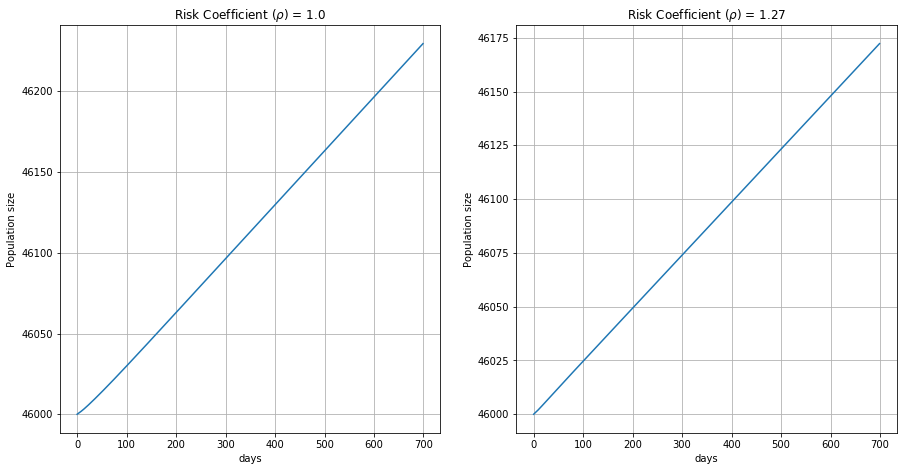

In [7]:
# N total
f4, ax4 = plt.subplots(1,2, figsize=(15,7.5))  
for r in range(len(RHO)): 
    solutions = RESULTS[r]
    
    plt.subplot(1,2,r+1)
    plt.plot(solutions[:,9],label = compartment_names[i])
    plt.title(r'Risk Coefficient ($\rho$) = '+str(RHO[r]))
    plt.xlabel('days')
    plt.ylabel('Population size')
    plt.grid()
    #plt.legend()

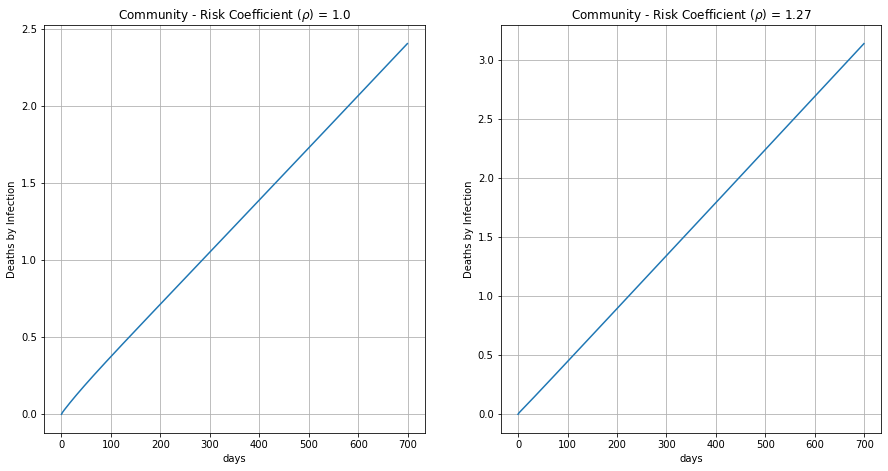

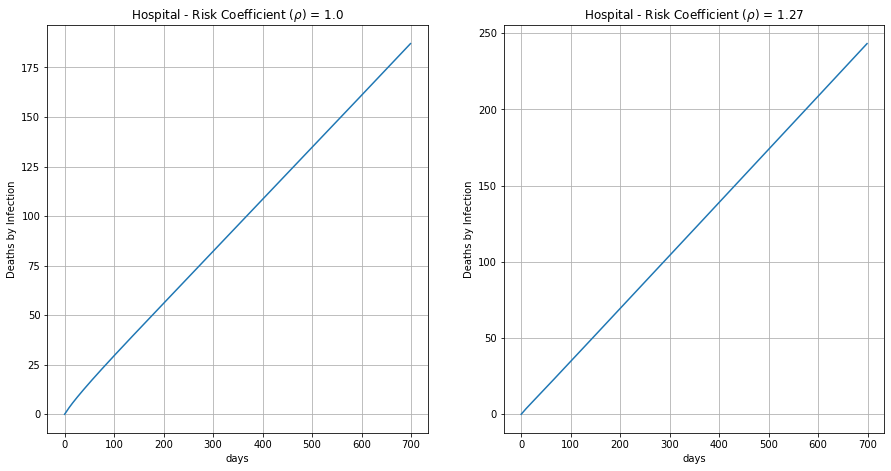

In [8]:
# Muertos ocasionados por infección

#En comunidad
f5, ax5 = plt.subplots(1,2, figsize=(15,7.5))  
for r in range(len(RHO)): 
    solutions = RESULTS[r]
    
    plt.subplot(1,2,r+1)
    plt.plot(solutions[:,6],label = compartment_names[i])
    plt.title(r'Community - Risk Coefficient ($\rho$) = '+str(RHO[r]))
    plt.xlabel('days')
    plt.ylabel('Deaths by Infection')
    plt.grid()
    #plt.legend()
    
#En hospital
f6, ax6 = plt.subplots(1,2, figsize=(15,7.5))  
for r in range(len(RHO)): 
    solutions = RESULTS[r]
    
    plt.subplot(1,2,r+1)
    plt.plot(solutions[:,7],label = compartment_names[i])
    plt.title(r'Hospital - Risk Coefficient ($\rho$) = '+str(RHO[r]))
    plt.xlabel('days')
    plt.ylabel('Deaths by Infection')
    plt.grid()
    #plt.legend()

# MONTECARLO CON BETA 

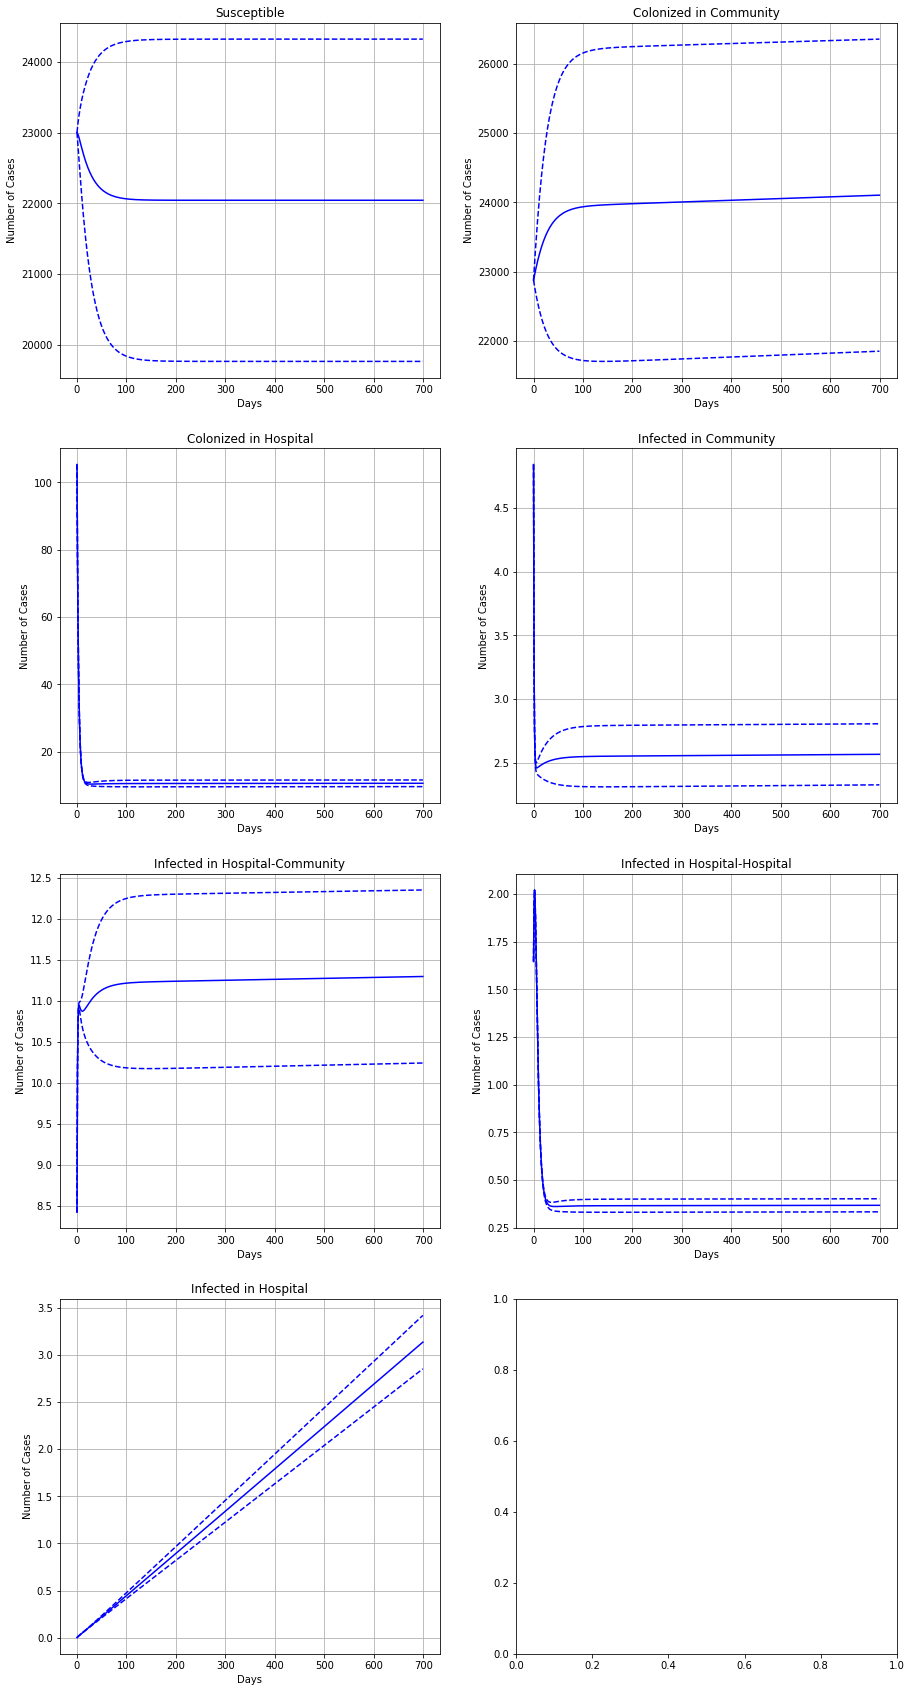

In [9]:
beta_mean = 0.0005308*0.18
beta_ste = ((0.0005308-0.0004775)/1.96)*0.18
BETA =  np.random.normal(beta_mean,beta_ste,1000)

RESULTS = []

for beta_i in BETA: 
    parameters = Lambda,phi,xi_C,xi_H,V_C,V_H,eta,alpha,gamma,beta_i,omega_H,omega_C,rho,delta_Z,delta_I,epsilon
    
    psoln = odeint(df1, y0, t, args=(parameters,)) #resolvemos el sistema
    IH = psoln[:,4]+psoln[:,5] #sumamos IH = IHH+IHC
    solutions = np.append(psoln,np.atleast_2d(IH).T, axis=1) #lo agregamos a la lista
    
    RESULTS.append(solutions)   


mean,low,up,MATRIZ = CI_v1(RESULTS)


f, ax = plt.subplots(4,2, figsize=(15,30))    

plt.subplot(4,2,1)
plt.plot(mean[0], linestyle = '-', color = 'blue')
plt.plot(low[0], linestyle = '--' , color = 'blue')
plt.plot(up[0], linestyle = '--', color = 'blue')
plt.title('Susceptible')
plt.xlabel('Days')
plt.ylabel('Number of Cases')
plt.grid()
 
plt.subplot(4,2,2)
plt.plot(mean[1], linestyle = '-', color = 'blue')
plt.plot(low[1], linestyle = '--' , color = 'blue')
plt.plot(up[1], linestyle = '--', color = 'blue')
plt.title('Colonized in Community')
plt.xlabel('Days')
plt.ylabel('Number of Cases')
plt.grid()

plt.subplot(4,2,3)
plt.plot(mean[2], linestyle = '-', color = 'blue')
plt.plot(low[2], linestyle = '--' , color = 'blue')
plt.plot(up[2], linestyle = '--', color = 'blue')
plt.title('Colonized in Hospital')
plt.xlabel('Days')
plt.ylabel('Number of Cases')
plt.grid()

plt.subplot(4,2,4)
plt.plot(mean[3], linestyle = '-', color = 'blue')
plt.plot(low[3], linestyle = '--' , color = 'blue')
plt.plot(up[3], linestyle = '--', color = 'blue')
plt.title('Infected in Community')
plt.xlabel('Days')
plt.ylabel('Number of Cases')
plt.grid()

plt.subplot(4,2,5)
plt.plot(mean[4], linestyle = '-', color = 'blue')
plt.plot(low[4], linestyle = '--' , color = 'blue')
plt.plot(up[4], linestyle = '--', color = 'blue')
plt.title('Infected in Hospital-Community')
plt.xlabel('Days')
plt.ylabel('Number of Cases')
plt.grid()

plt.subplot(4,2,6)
plt.plot(mean[5], linestyle = '-', color = 'blue')
plt.plot(low[5], linestyle = '--' , color = 'blue')
plt.plot(up[5], linestyle = '--', color = 'blue')
plt.title('Infected in Hospital-Hospital')
plt.xlabel('Days')
plt.ylabel('Number of Cases')
plt.grid()

plt.subplot(4,2,7)
plt.plot(mean[6], linestyle = '-', color = 'blue')
plt.plot(low[6], linestyle = '--' , color = 'blue')
plt.plot(up[6], linestyle = '--', color = 'blue')
plt.title('Infected in Hospital')
plt.xlabel('Days')
plt.ylabel('Number of Cases')
plt.grid()

# SENSIBILIDAD UNIVARIADO

# Hospitalization Rate for infected

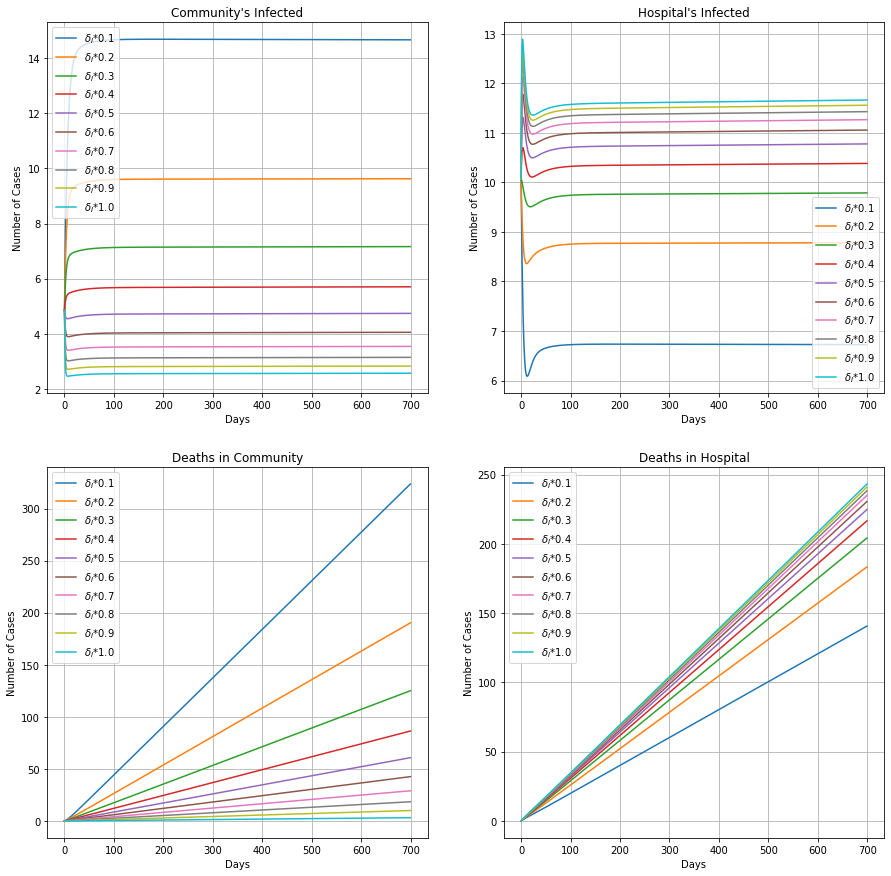

In [15]:
variation = np.array(range(1,11,1))/10 
DELTA_I = delta_I*variation
RESULTS = []

for i in range(len(DELTA_I)): 
    parameters = Lambda,phi,xi_C,xi_H,V_C,V_H,eta,alpha,gamma,beta,omega_H,omega_C,rho,delta_Z,DELTA_I[i],epsilon
    
    psoln = odeint(df1, y0, t, args=(parameters,)) #resolvemos el sistema
    IH = psoln[:,4]+psoln[:,5] #sumamos IH = IHH+IHC
    solutions = np.append(psoln,np.atleast_2d(IH).T, axis=1) #lo agregamos a la lista
    
    RESULTS.append(solutions)

f, ax = plt.subplots(2,2, figsize=(15,15))

plt.subplot(2,2,1)
for i in range(len(variation)): #Community Infected
    plt.plot(RESULTS[i][:,3], label = r'$\delta_I$*'+str(variation[i]))
    plt.title('Community\'s Infected')
    plt.xlabel('Days')
    plt.ylabel('Number of Cases')
plt.grid()
plt.legend()


plt.subplot(2,2,2)
for i in range(len(variation)): #Hospital Infected
    plt.plot(RESULTS[i][:,8], label = r'$\delta_I$*'+str(variation[i]))
    plt.title('Hospital\'s Infected')
    plt.xlabel('Days')
    plt.ylabel('Number of Cases')
plt.legend()
plt.grid()

plt.subplot(2,2,3)
for i in range(len(variation)): #Deaths in Community 
    plt.plot(RESULTS[i][:,6], label = r'$\delta_I$*'+str(variation[i]))
    plt.title('Deaths in Community')
    plt.xlabel('Days')
    plt.ylabel('Number of Cases')
plt.legend()
plt.grid()

plt.subplot(2,2,4)
for i in range(len(variation)): #Deaths in Hospital
    plt.plot(RESULTS[i][:,7], label = r'$\delta_I$*'+str(variation[i]))
    plt.title('Deaths in Hospital')
    plt.xlabel('Days')
    plt.ylabel('Number of Cases')
plt.legend()
plt.grid()

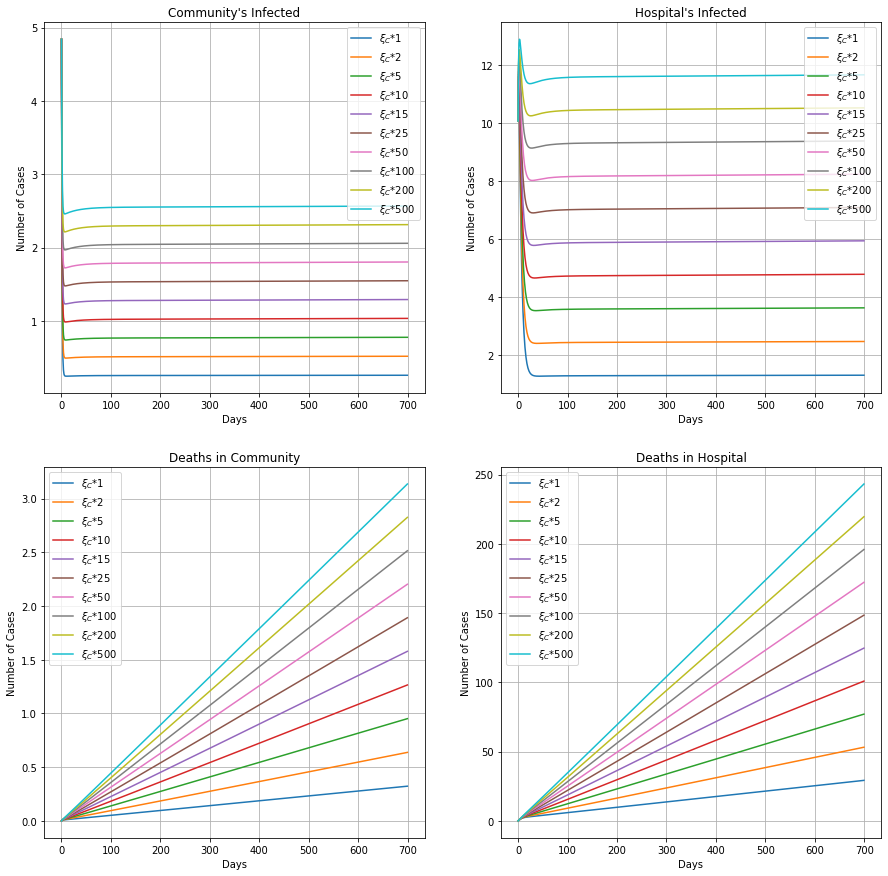

In [38]:
variation_XI_C = np.array([1,2,5,10,15,25,50,100,200,500])
XI_C = xi_C*variation
RESULTS = []

for i in range(len(DELTA_I)): 
    parameters = Lambda,phi,XI_C[i],xi_H,V_C,V_H,eta,alpha,gamma,beta,omega_H,omega_C,rho,delta_Z,delta_I,epsilon
    
    psoln = odeint(df1, y0, t, args=(parameters,)) #resolvemos el sistema
    IH = psoln[:,4]+psoln[:,5] #sumamos IH = IHH+IHC
    solutions = np.append(psoln,np.atleast_2d(IH).T, axis=1) #lo agregamos a la lista
    
    RESULTS.append(solutions)

f, ax = plt.subplots(2,2, figsize=(15,15))

plt.subplot(2,2,1)
for i in range(len(variation)): #Community Infected
    plt.plot(RESULTS[i][:,3], label = r'$\xi_C$*'+str(variation_XI_C[i]))
    plt.title('Community\'s Infected')
    plt.xlabel('Days')
    plt.ylabel('Number of Cases')
plt.grid()
plt.legend()


plt.subplot(2,2,2)
for i in range(len(variation)): #Hospital Infected
    plt.plot(RESULTS[i][:,8], label = r'$\xi_C$*'+str(variation_XI_C[i]))
    plt.title('Hospital\'s Infected')
    plt.xlabel('Days')
    plt.ylabel('Number of Cases')
plt.legend()
plt.grid()

plt.subplot(2,2,3)
for i in range(len(variation)): #Deaths in Community 
    plt.plot(RESULTS[i][:,6], label = r'$\xi_C$*'+str(variation_XI_C[i]))
    plt.title('Deaths in Community')
    plt.xlabel('Days')
    plt.ylabel('Number of Cases')
plt.legend()
plt.grid()

plt.subplot(2,2,4)
for i in range(len(variation)): #Deaths in Hospital
    plt.plot(RESULTS[i][:,7], label = r'$\xi_C$*'+str(variation_XI_C[i]))
    plt.title('Deaths in Hospital')
    plt.xlabel('Days')
    plt.ylabel('Number of Cases')
plt.legend()
plt.grid()

# SENSIBILIDAD BIVARIADO

# Probability of infection in community VS Hospitalization rate for infected

In [60]:
#genera resultados

variation_XI_C = np.array([1,2,5,10,15,25,50,100,200,500])
variation_DELTA_I = np.array(range(1,11,1))/10


XI_C = xi_C*variation_XI_C
DELTA_I = delta_I*variation_DELTA_I

label_xi_C = []
label_delta_I = []

RESULTS = []

for i in range(len(variation_XI_C)): #run through XI_C 
    RESULTS_i = []
    print(i)
    for j in range(len(DELTA_I)): #run through DELTA_I
        if i==0:
            
            label_delta_I.append(str(variation_DELTA_I[j])+r'*$\delta_I$')
            
        parameters = Lambda,phi,XI_C[i],xi_H,V_C,V_H,eta,alpha,gamma,beta,omega_H,omega_C,rho,delta_Z,DELTA_I[j],epsilon
    
        psoln = odeint(df1, y0, t, args=(parameters,)) #resolvemos el sistema
        IH = psoln[:,4]+psoln[:,5] #sumamos IH = IHH+IHC
        solutions = np.append(psoln,np.atleast_2d(IH).T, axis=1) #lo agregamos a la lista
    
        RESULTS_i.append(solutions)
    

    label_xi_C.append(str(variation_XI_C[i])+r'*$\xi_C$')
    
    
    
    RESULTS.append(RESULTS_i)

0
1
2
3
4
5
6
7
8
9


In [64]:
#recolectar valores

INFECTIONS_COMMUNITY = np.zeros([len(variation_XI_C),len(variation_DELTA_I)])
INFECTIONS_HOSPITAL = np.zeros([len(variation_XI_C),len(variation_DELTA_I)])
DEATHS_COMMUNITY = np.zeros([len(variation_XI_C),len(variation_DELTA_I)])

for i in range(len(XI_C)):
    for j in range(len(DELTA_I)):
        INFECTIONS_COMMUNITY[i,j] = RESULTS[i][j][699,3]
        INFECTIONS_HOSPITAL[i,j] = RESULTS[i][j][699,8]
        DEATHS_COMMUNITY[i,j]=RESULTS[i][j][699,6]
        
INFECTIONS_COMMUNITY = pd.DataFrame(INFECTIONS_COMMUNITY)
INFECTIONS_HOSPITAL = pd.DataFrame(INFECTIONS_HOSPITAL)
DEATHS_COMMUNITY = pd.DataFrame(DEATHS_COMMUNITY)

In [59]:
print(np.array(range(1,11,1))/10)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


Text(83.0, 0.5, 'Probability of bacterial resistant bloodstream in community')

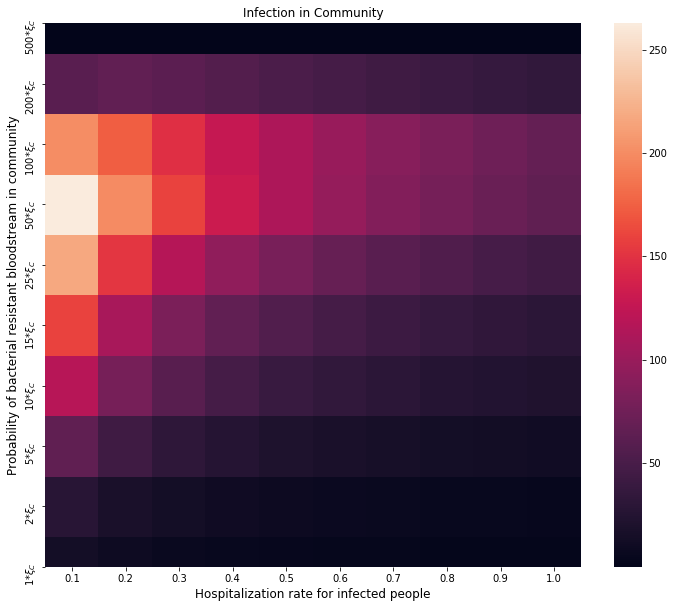

In [63]:
#gráficas

f, ax = plt.subplots(1,1, figsize=(12,10))

plt.subplot(1,1,1)
ax1 = sns.heatmap(INFECTIONS_COMMUNITY, xticklabels = label_delta_I, yticklabels = label_xi_C)
ax1.invert_yaxis()
plt.title('Infection in Community')
plt.xlabel('Hospitalization rate for infected people', fontsize = 12) # x-axis label with fontsize 15
plt.ylabel('Probability of bacterial resistant bloodstream in community', fontsize = 12) # y-axis label with fontsize 15

#plt.subplot(1,2,2)
#ax2 = sns.heatmap(INFECTIONS_HOSPITAL, xticklabels = label_omega_C, yticklabels = label_xi_C)
#ax2.invert_yaxis()
#plt.title('Infection in Hospital')
#plt.xlabel('Antibiotic consumption in community', fontsize = 8) # x-axis label with fontsize 15
#plt.ylabel('Probability of bacterial resistant bloodstream in community', fontsize = 8) # y-axis label with fontsize 15


# Probability of infection in community VS Treatment in community 

In [68]:
#genera resultados

variation_XI_C = np.array([1,2,5,10,15,25,50,100,200,500])
variation_OMEGA_C = np.array([0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 2.0, 2.4,3])


XI_C = xi_C*variation_XI_C
OMEGA_C = omega_C*variation_OMEGA_C

label_xi_C = []
label_omega_C = []

RESULTS = []

for i in range(len(variation_XI_C)): #run through XI_C 
    RESULTS_i = []
    print(i)
    for j in range(len(variation_OMEGA_C)): #run through DELTA_I
        if i==0:
            
            label_omega_C.append(str(variation_OMEGA_C[j])+r'*$\omega_C$')
            
        parameters = Lambda,phi,XI_C[i],xi_H,V_C,V_H,eta,alpha,gamma,beta,omega_H,OMEGA_C[j],rho,delta_Z,delta_I,epsilon
    
        psoln = odeint(df1, y0, t, args=(parameters,)) #resolvemos el sistema
        IH = psoln[:,4]+psoln[:,5] #sumamos IH = IHH+IHC
        solutions = np.append(psoln,np.atleast_2d(IH).T, axis=1) #lo agregamos a la lista
    
        RESULTS_i.append(solutions)
    

    label_xi_C.append(str(variation_XI_C[i])+r'*$\xi_C$')
    
    
    
    RESULTS.append(RESULTS_i)

0
1
2
3
4
5
6
7
8
9


In [69]:
#recolectar valores

INFECTIONS_COMMUNITY = np.zeros([len(variation_XI_C),len(variation_OMEGA_C)])
INFECTIONS_HOSPITAL = np.zeros([len(variation_XI_C),len(variation_OMEGA_C)])
DEATHS_COMMUNITY = np.zeros([len(variation_XI_C),len(variation_OMEGA_C)])

for i in range(len(XI_C)):
    for j in range(len(OMEGA_C)):
        INFECTIONS_COMMUNITY[i,j] = RESULTS[i][j][699,3]
        INFECTIONS_HOSPITAL[i,j] = RESULTS[i][j][699,8]
        DEATHS_COMMUNITY[i,j]=RESULTS[i][j][699,6]
        
INFECTIONS_COMMUNITY = pd.DataFrame(INFECTIONS_COMMUNITY)
INFECTIONS_HOSPITAL = pd.DataFrame(INFECTIONS_HOSPITAL)
DEATHS_COMMUNITY = pd.DataFrame(DEATHS_COMMUNITY)

Text(83.0, 0.5, 'Probability of bacterial resistant bloodstream in community')

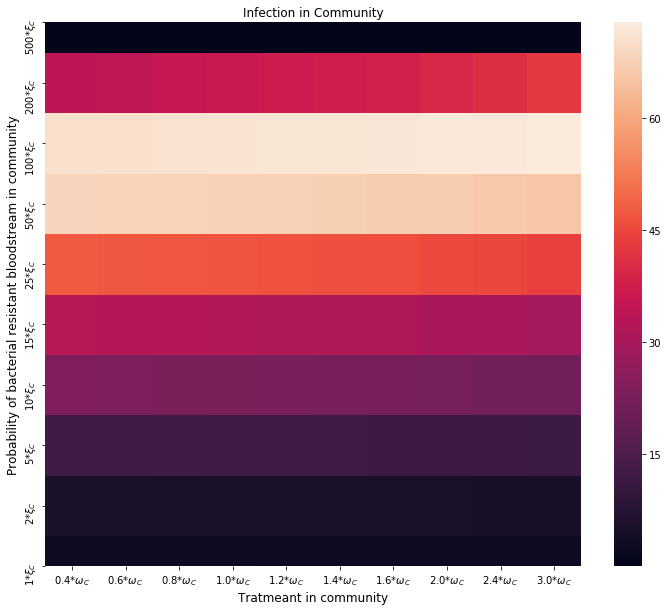

In [70]:
#gráficas

f, ax = plt.subplots(1,1, figsize=(12,10))

plt.subplot(1,1,1)
ax1 = sns.heatmap(INFECTIONS_COMMUNITY, xticklabels = label_omega_C, yticklabels = label_xi_C)
ax1.invert_yaxis()
plt.title('Infection in Community')
plt.xlabel('Tratmeant in community', fontsize = 12) # x-axis label with fontsize 15
plt.ylabel('Probability of bacterial resistant bloodstream in community', fontsize = 12) # y-axis label with fontsize 15

#plt.subplot(1,2,2)
#ax2 = sns.heatmap(INFECTIONS_HOSPITAL, xticklabels = label_omega_C, yticklabels = label_xi_C)
#ax2.invert_yaxis()
#plt.title('Infection in Hospital')
#plt.xlabel('Antibiotic consumption in community', fontsize = 8) # x-axis label with fontsize 15
#plt.ylabel('Probability of bacterial resistant bloodstream in community', fontsize = 8) # y-axis label with fontsize 15


# Probability of infection in hospital VS Treatment in community 

In [74]:
#genera resultados

variation_XI_H = np.array([1,2,5,10,15,25,50,100,200,500])
variation_OMEGA_H = np.array([0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 2.0, 2.4,3])


XI_H = xi_C*variation_XI_H
OMEGA_H = omega_C*variation_OMEGA_H

label_xi_H = []
label_omega_H = []

RESULTS = []

for i in range(len(variation_XI_H)): #run through XI_H
    RESULTS_i = []
    print(i)
    for j in range(len(variation_OMEGA_H)): #run through OMEGA_H
        if i==0:
            
            label_omega_H.append(str(variation_OMEGA_H[j])+r'*$\omega_H$')
            
        parameters = Lambda,phi,xi_C,XI_H[i],V_C,V_H,eta,alpha,gamma,beta,OMEGA_H[j],omega_C,rho,delta_Z,delta_I,epsilon
    
        psoln = odeint(df1, y0, t, args=(parameters,)) #resolvemos el sistema
        IH = psoln[:,4]+psoln[:,5] #sumamos IH = IHH+IHC
        solutions = np.append(psoln,np.atleast_2d(IH).T, axis=1) #lo agregamos a la lista
    
        RESULTS_i.append(solutions)
    

    label_xi_H.append(str(variation_XI_C[i])+r'*$\xi_H$')
    
    
    
    RESULTS.append(RESULTS_i)

0
1
2
3
4
5
6
7
8
9


In [75]:
#recolectar valores

INFECTIONS_COMMUNITY = np.zeros([len(variation_XI_H),len(variation_OMEGA_H)])
INFECTIONS_HOSPITAL = np.zeros([len(variation_XI_H),len(variation_OMEGA_H)])
DEATHS_COMMUNITY = np.zeros([len(variation_XI_H),len(variation_OMEGA_H)])

for i in range(len(XI_H)):
    for j in range(len(OMEGA_H)):
        INFECTIONS_COMMUNITY[i,j] = RESULTS[i][j][699,3]
        INFECTIONS_HOSPITAL[i,j] = RESULTS[i][j][699,8]
        DEATHS_COMMUNITY[i,j]=RESULTS[i][j][699,6]
        
INFECTIONS_COMMUNITY = pd.DataFrame(INFECTIONS_COMMUNITY)
INFECTIONS_HOSPITAL = pd.DataFrame(INFECTIONS_HOSPITAL)
DEATHS_COMMUNITY = pd.DataFrame(DEATHS_COMMUNITY)

Text(83.0, 0.5, 'Probability of bacterial resistant bloodstream in hospital')

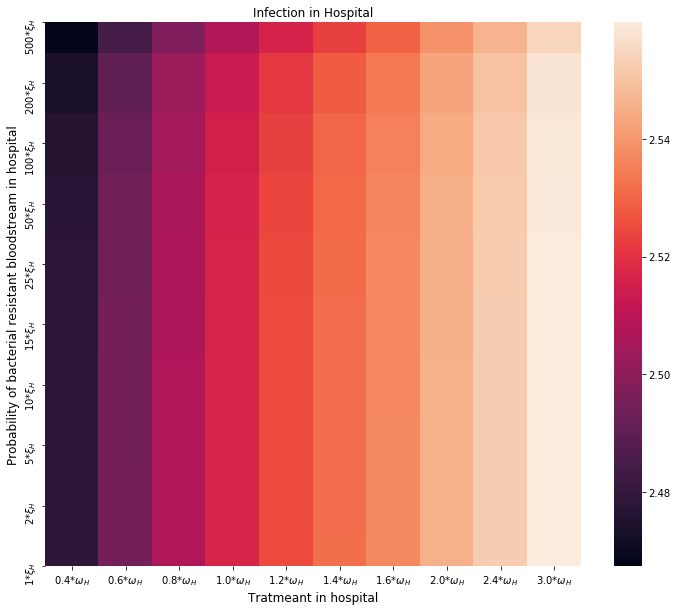

In [76]:
#gráficas

f, ax = plt.subplots(1,1, figsize=(12,10))

plt.subplot(1,1,1)
ax1 = sns.heatmap(INFECTIONS_COMMUNITY, xticklabels = label_omega_H, yticklabels = label_xi_H)
ax1.invert_yaxis()
plt.title('Infection in Hospital')
plt.xlabel('Tratmeant in hospital', fontsize = 12) # x-axis label with fontsize 15
plt.ylabel('Probability of bacterial resistant bloodstream in hospital', fontsize = 12) # y-axis label with fontsize 15

#plt.subplot(1,2,2)
#ax2 = sns.heatmap(INFECTIONS_HOSPITAL, xticklabels = label_omega_C, yticklabels = label_xi_C)
#ax2.invert_yaxis()
#plt.title('Infection in Hospital')
#plt.xlabel('Antibiotic consumption in community', fontsize = 8) # x-axis label with fontsize 15
#plt.ylabel('Probability of bacterial resistant bloodstream in community', fontsize = 8) # y-axis label with fontsize 15


# Calculating $R_0$

Version 1

Consider the "infeted compartmen"t the colonized and infected ones 

In [11]:
F = np.array([[rho*epsilon*beta*S_0,0,0,0],
             [0,0,0,0],
             [0,0,0,0],
             [0,0,0,0]])

V = np.array([[xi_C*(1-gamma)*(1-delta_Z)+delta_Z+gamma+phi,0,-omega_C,-omega_H],
            [-delta_Z,xi_H*(1-alpha)+phi+gamma,0,0],
            [-xi_C*(1-gamma)*(1-delta_Z),0,delta_I+omega_C+phi+(1-omega_C)*(1-delta_I)*eta*V_C,0],
            [0,-xi_H*(1-alpha),delta_I,omega_H+(1-omega_H)*eta*V_H+phi]])

FV_1 = np.matmul(F,np.linalg.inv(V))
print(FV_1)

[[ 1.0411848   0.16424797 -0.80479119  0.89660068]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
